In [1]:
import pyspark as ps
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = ps.sql.SparkSession.builder.appName("Spark-Toulouse-Real-Estate").getOrCreate()

In [3]:
spark

In [4]:
# Create schema
Re_schema = StructType([StructField("SaleDate", StringType(), False),
                       StructField("SaleType", StringType(), False),
                       StructField("Price", IntegerType(), False),
                       StructField("PostCode", IntegerType(), False),
                        StructField("City", StringType(), False),
                        StructField("NbRooms", IntegerType(), False),
                        StructField("NbLots", IntegerType(), False),
                        StructField("ResidenceType", StringType(), False),
                        StructField("LivingArea", IntegerType(), False),
                        StructField("LandArea", IntegerType(), False)
                       ])

In [5]:
# Import csv in pyspark
df = spark.read.csv("project_data_real_estate_toulouse_and_suburbs.csv", sep =';', header=True, schema=Re_schema)
df.printSchema()

root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- PostCode: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



In [6]:
# Change type of column SaleDate to date 
df = df.withColumn('SaleDate',to_date(df.SaleDate, 'dd/MM/yyyy'))
df.printSchema()

root
 |-- SaleDate: date (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- PostCode: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



In [7]:
df.show(10)

+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|2019-01-15|                SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|2019-01-21|                SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|2019-01-03|                SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|2019-01-11|                SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|2019-01-15|                SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|2019-01-15|                SALE|209300|   31270

In [8]:
# Create temporary view for SQl query 
df.createOrReplaceTempView('realestate')

In [9]:
# Query the whole dataframe to verify if it works 
re_all = spark.sql("SELECT * FROM realestate")
re_all.show()

+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|2019-01-15|                SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|2019-01-21|                SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|2019-01-03|                SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|2019-01-11|                SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|2019-01-15|                SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|2019-01-15|                SALE|209300|   31270

In [10]:
# Number of Cities 
count_cities = spark.sql("SELECT COUNT(DISTINCT City) FROM realestate")
count_cities.show()

+--------------------+
|count(DISTINCT City)|
+--------------------+
|                  26|
+--------------------+



In [11]:
# Years in the dataset
years = spark.sql("SELECT DISTINCT YEAR(SaleDate) AS YEARS FROM realestate ORDER BY YEARS")
years.show()

+-----+
|YEARS|
+-----+
| 2015|
| 2016|
| 2017|
| 2018|
| 2019|
+-----+



In [12]:
# Sale Type
sale_type = spark.sql("SELECT DISTINCT SaleType FROM realestate")
sale_type.show()

+--------------------+
|            SaleType|
+--------------------+
|SALE BEFORE COMPL...|
|                SALE|
+--------------------+



<h2>1) Outliers</h2>

In [13]:
# Compute median, Q1, Q3, IQR
median = df.approxQuantile("Price", [0.5], 0)
Q1 = df.approxQuantile("Price", [0.25], 0)
Q3 = df.approxQuantile("Price", [0.75], 0)
IQR = Q3[0]-Q1[0]
print(f"Q1: {Q1[0]}, Median:{median[0]}, Q3: {Q3[0]}, IQR:{IQR}")

Q1: 122500.0, Median:180000.0, Q3: 280000.0, IQR:157500.0


In [14]:
# Lower bond outliers (1.5*IQR) (there are no outliers with low price)
lower_outliers = spark.sql("SELECT SaleDate, City, Price, LivingArea, LandArea, ResidenceType, nbRooms, NbLots FROM realestate WHERE Price<=122500-(1.5*157500)")
lower_outliers.show()

+--------+----+-----+----------+--------+-------------+-------+------+
|SaleDate|City|Price|LivingArea|LandArea|ResidenceType|nbRooms|NbLots|
+--------+----+-----+----------+--------+-------------+-------+------+
+--------+----+-----+----------+--------+-------------+-------+------+



In [15]:
# Upper outliers (10*IQR)
upper_outliers = spark.sql("SELECT SaleDate, City, Price, LivingArea, LandArea, ResidenceType, nbRooms, NbLots FROM realestate WHERE Price>=280000+(10*157500) ORDER BY Price DESC")
upper_outliers.show(200)

+----------+----------+--------+----------+--------+-------------+-------+------+
|  SaleDate|      City|   Price|LivingArea|LandArea|ResidenceType|nbRooms|NbLots|
+----------+----------+--------+----------+--------+-------------+-------+------+
|2015-04-08|  TOULOUSE|33427218|        63|       0|    APARTMENT|      3|     1|
|2015-04-08|  TOULOUSE|33427218|        67|   14386|    APARTMENT|      3|     0|
|2015-04-08|  TOULOUSE|33427218|        44|       0|    APARTMENT|      2|     1|
|2015-04-08|  TOULOUSE|33427218|        86|   14386|    APARTMENT|      4|     0|
|2015-04-08|  TOULOUSE|33427218|        81|       0|    APARTMENT|      4|     1|
|2015-04-08|  TOULOUSE|33427218|        64|       0|    APARTMENT|      3|     1|
|2015-04-08|  TOULOUSE|33427218|        63|       0|    APARTMENT|      3|     1|
|2015-04-08|  TOULOUSE|33427218|        74|       0|    APARTMENT|      4|     1|
|2015-04-08|  TOULOUSE|33427218|        83|    3872|    APARTMENT|      4|     0|
|2015-04-08|  TO

<AxesSubplot:xlabel='Price'>

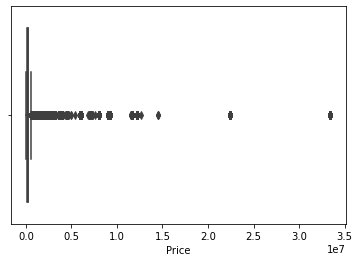

In [63]:
# Convert to Pandas dataframe 
data_df = re_all.toPandas()

# Plot the Price distribution 
sns.boxplot(x=data_df["Price"])

There are many outliers in the dataset, more than 25% of the observations. 

There are many inconsistencies in the distribution of prices, for example with the city of Toulouse.

The observations range between 0 and 50,000,000 €, some of them are above this price

In [19]:
# Drop all the rows with sale price above 50,000,000€
df = df.where("Price<5000000")

In [20]:
# Create NEW temporary view for SQl query 
df.createOrReplaceTempView('realestatetls')

In [21]:
# Compute AGAIN median, Q1, Q3, IQR 
median = df.approxQuantile("Price", [0.5], 0)
Q1 = df.approxQuantile("Price", [0.25], 0)
Q3 = df.approxQuantile("Price", [0.75], 0)
IQR = Q3[0]-Q1[0]
print(f"Q1: {Q1[0]}, Median:{median[0]}, Q3: {Q3[0]}, IQR:{IQR}")

Q1: 120762.0, Median:177373.0, Q3: 269000.0, IQR:148238.0


Given the price distribution, we choose to keep only the prices of sales less than or equal to 50,000,000 €.

Computing again the sample to see lower highs and lower lows.

<h2>2) Sales Information by Year</h2>

In [24]:
# Sales information by year 
sales_by_years = spark.sql("SELECT YEAR(SaleDate) as YEARS, COUNT(*) as NUMBER_OF_SALES, SUM(Price) as TOTAL_SALES, ROUND(SUM(Price)/COUNT(*),2) AS AVG_PRICE, ROUND(AVG(Price/LivingArea),2) as AVG_PRICE_LIVING_M2, ROUND(AVG(Price/LandArea),2) as AVG_PRICE_LAND_M2, ROUND(AVG(NbRooms),2) as AVG_ROOMS, ROUND(AVG(NbLots),2) as AVG_LOTS FROM realestatetls GROUP BY EXTRACT(YEAR FROM SaleDate) ORDER BY YEARS")
sales_by_years.show()

+-----+---------------+-----------+---------+-------------------+-----------------+---------+--------+
|YEARS|NUMBER_OF_SALES|TOTAL_SALES|AVG_PRICE|AVG_PRICE_LIVING_M2|AVG_PRICE_LAND_M2|AVG_ROOMS|AVG_LOTS|
+-----+---------------+-----------+---------+-------------------+-----------------+---------+--------+
| 2015|          17118| 4159349475|242981.04|            4148.48|          1026.48|     2.99|     1.1|
| 2016|          17151| 4889281020|285072.65|            5300.67|          1483.99|     2.96|    1.05|
| 2017|          19491| 5351176812|274546.04|            5613.44|          1388.97|     2.99|    1.05|
| 2018|          16319| 4346909296|266371.06|            4484.98|           1492.2|      3.1|     1.0|
| 2019|           5433| 1330292020|244854.04|            4521.95|          1481.25|     3.03|    1.04|
+-----+---------------+-----------+---------+-------------------+-----------------+---------+--------+



In [58]:
# Convert to Pandas dataframe 
sales_years_df = sales_by_years.toPandas()

<AxesSubplot:xlabel='YEARS', ylabel='AVG_LOTS'>

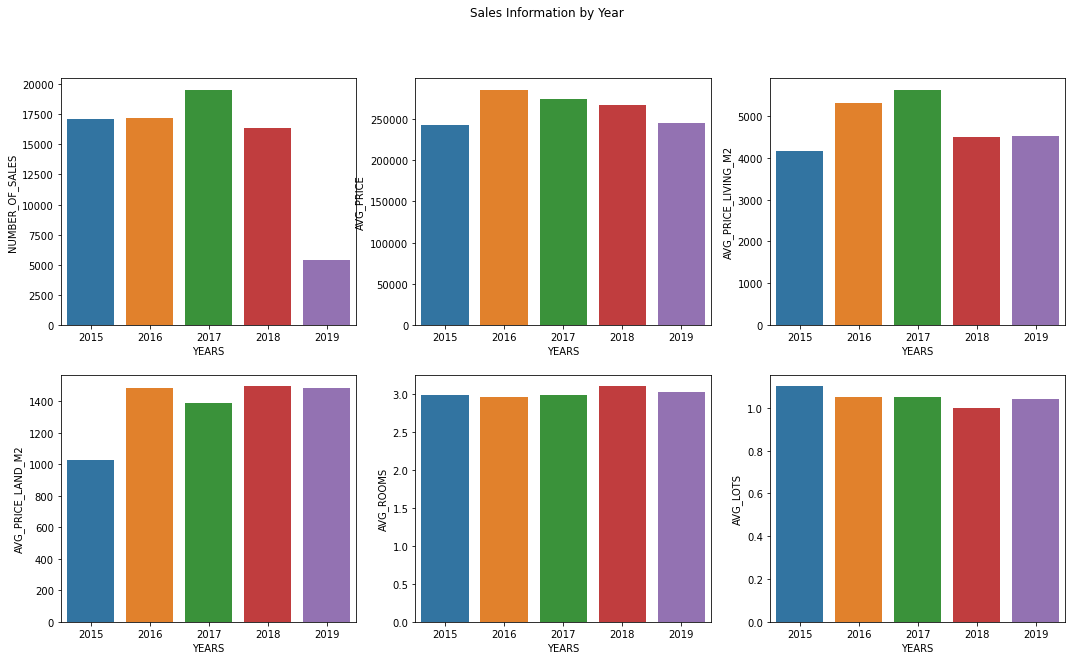

In [59]:
# Plot the data by Year
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Sales Information by Year')

sns.barplot(ax=axes[0, 0], data=sales_years_df, y='NUMBER_OF_SALES',x='YEARS')
sns.barplot(ax=axes[0, 1], data=sales_years_df, y='AVG_PRICE',x='YEARS')
sns.barplot(ax=axes[0, 2], data=sales_years_df, y='AVG_PRICE_LIVING_M2', x='YEARS')
sns.barplot(ax=axes[1, 0], data=sales_years_df, y='AVG_PRICE_LAND_M2', x='YEARS')
sns.barplot(ax=axes[1, 1], data=sales_years_df, y='AVG_ROOMS', x='YEARS')
sns.barplot(ax=axes[1, 2], data=sales_years_df, y='AVG_LOTS', x='YEARS')

The year 2017 was very conclusive in terms of sales although the price per square meter was the highest of the 5 years studied.

The year 2019 was the least remarkable in terms of sales although the price per square meter decreased. 

It should also be noted that the properties sold in all 5 years were around 3 rooms. 

The year 2018 saw a few more properties with more than 3 rooms go on sale, although the results are below the previous years.

<h2>3) Sales Information by Month</h2>

In [25]:
# Sales information by month 
sales_by_month = spark.sql("SELECT MONTH(SaleDate) as MONTH, COUNT(*) as NUMBER_OF_SALES, SUM(Price) as TOTAL_SALES, ROUND(SUM(Price)/COUNT(*),2) AS AVG_PRICE, ROUND(AVG(Price/LivingArea),2) as AVG_PRICE_LIVING_M2, ROUND(AVG(Price/LandArea),2) as AVG_PRICE_LAND_M2, ROUND(AVG(NbRooms),2) as AVG_ROOMS, ROUND(AVG(NbLots),2) as AVG_LOTS FROM realestatetls GROUP BY EXTRACT(MONTH FROM SaleDate) ORDER BY MONTH")
sales_by_month.show()

+-----+---------------+-----------+---------+-------------------+-----------------+---------+--------+
|MONTH|NUMBER_OF_SALES|TOTAL_SALES|AVG_PRICE|AVG_PRICE_LIVING_M2|AVG_PRICE_LAND_M2|AVG_ROOMS|AVG_LOTS|
+-----+---------------+-----------+---------+-------------------+-----------------+---------+--------+
|    1|           5600| 1390949554|248383.85|            4173.42|          1369.53|     3.03|    1.05|
|    2|           5939| 1354882304|228133.07|            3777.41|          1290.66|     3.04|    1.12|
|    3|           6644| 1534652858|230983.27|            4110.71|          1644.24|     2.99|    1.07|
|    4|           5677| 1496842445|263667.86|            4881.86|          1708.82|     3.03|    1.06|
|    5|           5390| 1200194474|222670.59|            3600.83|          1344.98|     3.04|    1.06|
|    6|           7281| 1919137097|263581.53|            4843.05|          1331.56|     2.98|    1.05|
|    7|           7500| 1885160450|251354.73|            4205.39|        

In [55]:
# Convert to Pandas dataframe 
sales_month_df = sales_by_month.toPandas()

<AxesSubplot:xlabel='MONTH', ylabel='AVG_LOTS'>

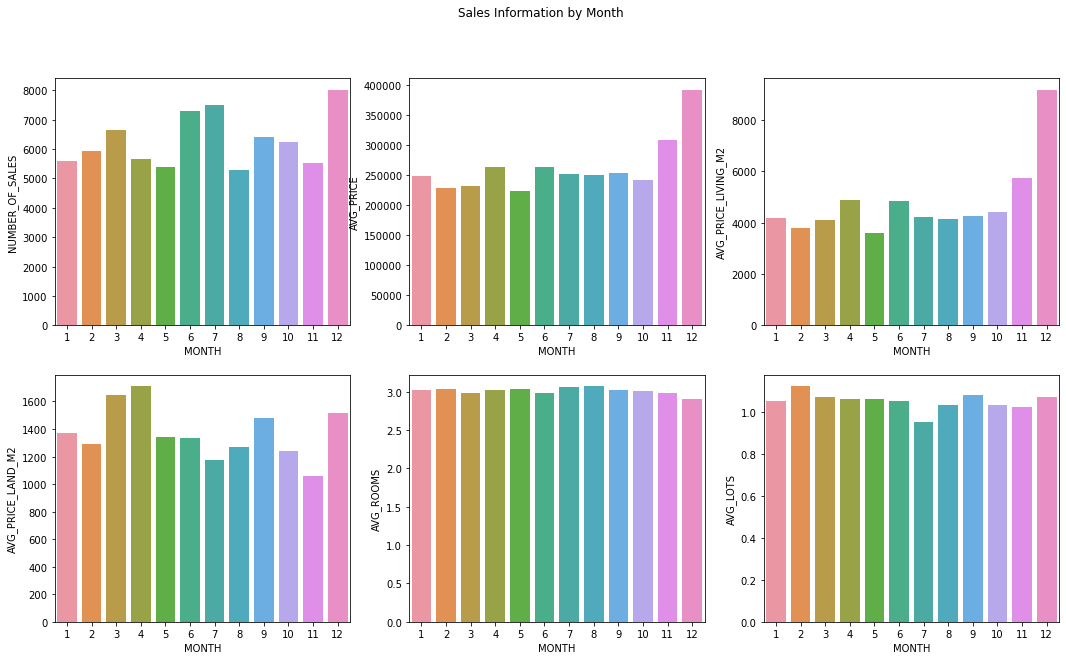

In [57]:
# Plot the data by month
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Sales Information by Month')

sns.barplot(ax=axes[0, 0], data=sales_month_df, y='NUMBER_OF_SALES',x='MONTH')
sns.barplot(ax=axes[0, 1], data=sales_month_df, y='AVG_PRICE',x='MONTH')
sns.barplot(ax=axes[0, 2], data=sales_month_df, y='AVG_PRICE_LIVING_M2', x='MONTH')
sns.barplot(ax=axes[1, 0], data=sales_month_df, y='AVG_PRICE_LAND_M2', x='MONTH')
sns.barplot(ax=axes[1, 1], data=sales_month_df, y='AVG_ROOMS', x='MONTH')
sns.barplot(ax=axes[1, 2], data=sales_month_df, y='AVG_LOTS', x='MONTH')

We can see that sales were strong at the end of the summer period and at the end of the year with Christmas.

The highest average price for properties is reached in December, with a particular distinction compared to the other months of the year. 
Indeed, the price per square meter is twice as expensive in January as in December. 

The price land per square meter is also high in December but less than in April when the price of bare land is more than 1600€/m².
At the beginning of the year and at the end of the summer, the properties for sale have more than 3 rooms on average, and an average of more than 1 lot in February.

<h2>4) Sales information by City</h2>

In [28]:
# Sales information by Cities
sales_by_cities = spark.sql("SELECT DISTINCT City AS CITY, COUNT(*) as NUMBER_OF_SALES, SUM(Price) as TOTAL_SALES, ROUND(SUM(Price)/COUNT(*),2) AS AVG_PRICE, ROUND(AVG(Price/LivingArea),2) as AVG_PRICE_LIVING_M2, ROUND(AVG(Price/LandArea),2) as AVG_PRICE_LAND_M2, ROUND(AVG(NbRooms),2) as AVG_ROOMS, ROUND(AVG(NbLots),2) as AVG_LOTS FROM realestatetls GROUP BY CITY ORDER BY NUMBER_OF_SALES DESC")
sales_by_cities.show(26)

+--------------------+---------------+-----------+---------+-------------------+-----------------+---------+--------+
|                CITY|NUMBER_OF_SALES|TOTAL_SALES|AVG_PRICE|AVG_PRICE_LIVING_M2|AVG_PRICE_LAND_M2|AVG_ROOMS|AVG_LOTS|
+--------------------+---------------+-----------+---------+-------------------+-----------------+---------+--------+
|            TOULOUSE|          48715|12682183016|260334.25|            5405.58|          2067.73|     2.76|    1.11|
|             BLAGNAC|           4812| 1376100608|285972.69|            4318.07|           923.71|     3.08|    1.34|
|           COLOMIERS|           2700|  874356774|323835.84|            6027.85|           856.39|      3.4|    0.86|
|       TOURNEFEUILLE|           2339|  811805038|347073.55|            4816.15|            692.6|     3.55|    1.08|
|             CUGNAUX|           1687|  437832069|259532.94|            3667.01|           706.22|      3.4|    1.24|
|               MURET|           1345|  261658924|194541

In [43]:
# Convert to Pandas dataframe 
sales_cities_df = sales_by_cities.toPandas()

<AxesSubplot:xlabel='AVG_LOTS', ylabel='CITY'>

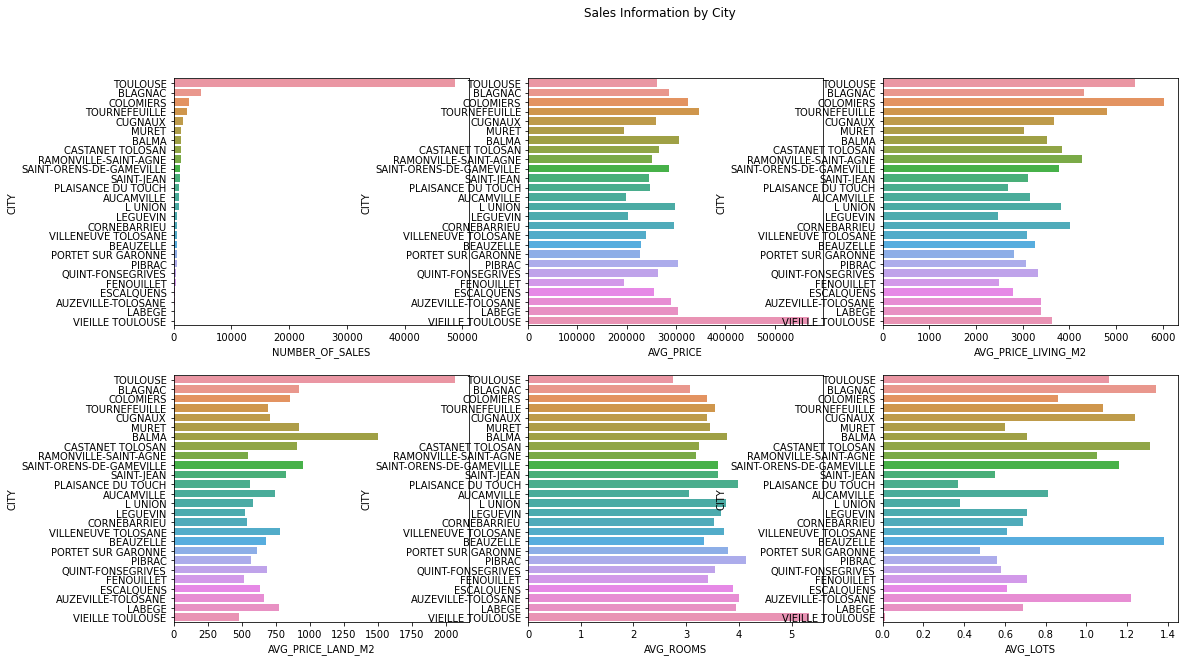

In [49]:
# Plot the data by city 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Sales Information by City')

sns.barplot(ax=axes[0, 0], data=sales_cities_df, x='NUMBER_OF_SALES',y='CITY')
sns.barplot(ax=axes[0, 1], data=sales_cities_df, x='AVG_PRICE',y='CITY')
sns.barplot(ax=axes[0, 2], data=sales_cities_df, x='AVG_PRICE_LIVING_M2', y='CITY')
sns.barplot(ax=axes[1, 0], data=sales_cities_df, x='AVG_PRICE_LAND_M2', y='CITY')
sns.barplot(ax=axes[1, 1], data=sales_cities_df, x='AVG_ROOMS', y='CITY')
sns.barplot(ax=axes[1, 2], data=sales_cities_df, x='AVG_LOTS', y='CITY')

The sales by city make it possible to identify that there are more sales in Toulouse than elsewhere, although the average price of the sales of the goods is clearly higher in the commune of "Vieille-Toulouse". 
The average price per square meter reaches 6,000€ in Colomiers while it is slightly above 5,000€ in Toulouse. 

Toulouse and Balma are the 2 cities where the price land per square meter is the highest, but there are more homes with more than 5 rooms in the commune of Vieille-Toulouse, which would suggest that this commune gathers inhabitants with more means than elsewhere given the few sales made.

<h2>5) Sales Information by Residence Type</h2>

In [51]:
# Sales by month in 2015 
residence_type = spark.sql("SELECT ResidenceType, COUNT(*) AS NUMBER_OF_SALES, ROUND(AVG(Price),2) AS AVG_PRICE, ROUND(AVG(LivingArea),2) AS AVG_PRICE_LIVING_M2, ROUND(AVG(LandArea),2) AS AVG_PRICE_LAND_M2, ROUND(AVG(NbRooms),2) AS AVG_ROOMS, ROUND(AVG(NbLots),2) AS AVG_LOTS FROM realestatetls GROUP BY ResidenceType")
residence_type.show()

+-------------+---------------+---------+-------------------+-----------------+---------+--------+
|ResidenceType|NUMBER_OF_SALES|AVG_PRICE|AVG_PRICE_LIVING_M2|AVG_PRICE_LAND_M2|AVG_ROOMS|AVG_LOTS|
+-------------+---------------+---------+-------------------+-----------------+---------+--------+
|        HOUSE|          17254|346867.42|             107.29|           513.24|     4.47|    0.17|
|    APARTMENT|          58258|241892.24|              55.43|            97.17|     2.58|    1.31|
+-------------+---------------+---------+-------------------+-----------------+---------+--------+



In [52]:
# Convert to Pandas dataframe 
residence_type_df = residence_type.toPandas()

<AxesSubplot:xlabel='ResidenceType', ylabel='AVG_LOTS'>

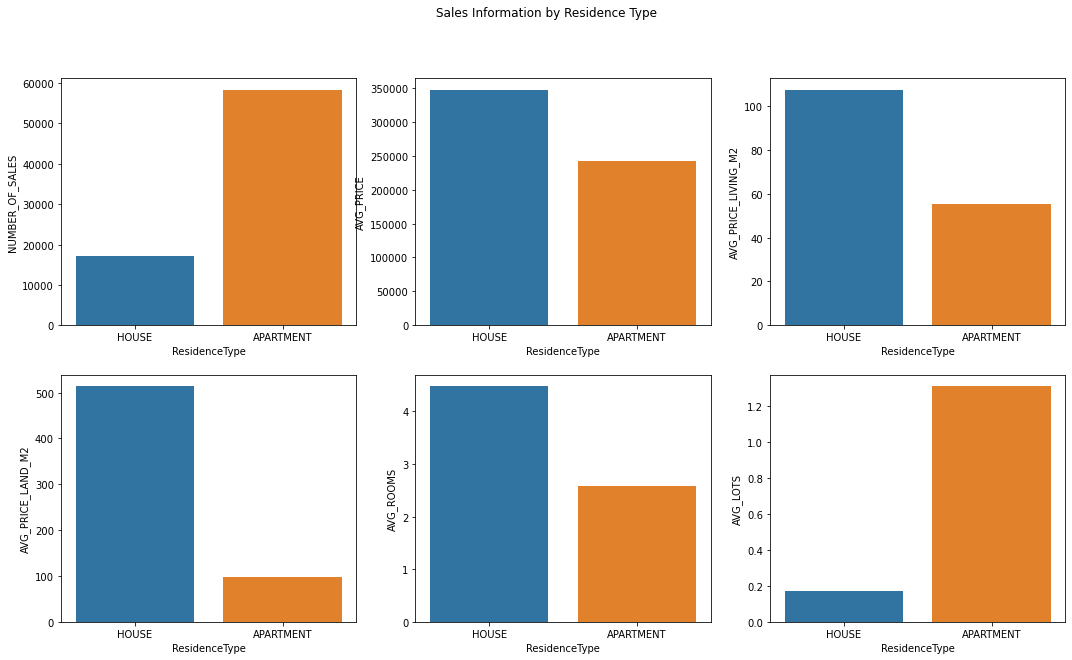

In [54]:
# Plot the data by city 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Sales Information by Residence Type')

sns.barplot(ax=axes[0, 0], data=residence_type_df, x='ResidenceType', y='NUMBER_OF_SALES')
sns.barplot(ax=axes[0, 1], data=residence_type_df, x='ResidenceType', y='AVG_PRICE')
sns.barplot(ax=axes[0, 2], data=residence_type_df, x='ResidenceType', y='AVG_PRICE_LIVING_M2')
sns.barplot(ax=axes[1, 0], data=residence_type_df, x='ResidenceType', y='AVG_PRICE_LAND_M2')
sns.barplot(ax=axes[1, 1], data=residence_type_df, x='ResidenceType', y='AVG_ROOMS')
sns.barplot(ax=axes[1, 2], data=residence_type_df, x='ResidenceType', y='AVG_LOTS')

Not surprisingly, more apartments are sold than houses. 

Obviously, the price of a house is on average 30% higher than that of an apartment, but the price land per square meter is also 5 times higher than that of apartments.

On average, there are more rooms in a house than in an apartment but more lots in an apartment than in a house.